<a href="https://colab.research.google.com/github/mtzig/LIDC_GDRO/blob/main/notebooks/LIDC_cnn_feature_subgroups.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!git clone https://github.com/mtzig/LIDC_GDRO.git
%cd /content/LIDC_GDRO
# %cd ..

Cloning into 'LIDC_GDRO'...
remote: Enumerating objects: 3471, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 3471 (delta 21), reused 25 (delta 10), pack-reused 3428
Receiving objects: 100% (3471/3471), 56.18 MiB | 12.03 MiB/s, done.
Resolving deltas: 100% (3169/3169), done.
Checking out files: 100% (5390/5390), done.
/content/LIDC_GDRO


In [32]:
# !git pull

remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4 (delta 3), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (4/4), done.
From https://github.com/mtzig/LIDC_GDRO
   4f9327d..b25d445  main       -> origin/main
Updating 4f9327d..b25d445
Fast-forward
 notebooks/run_test.ipynb | 4433 +++++++++++++++++++++++-----------------------
 1 file changed, 2261 insertions(+), 2172 deletions(-)


In [29]:
# import os
# import torch
import pandas as pd
# import numpy as np
from dataloaders import InfiniteDataLoader
from datasets import NoduleDataset, SubclassedNoduleDataset
from models import TransferModel, NeuralNetwork
from loss import ERMLoss#, GDROLossAlt, GDROLoss
from train import train, test
from torch.optim.lr_scheduler import ReduceLROnPlateau

# import torchvision
from torchvision import transforms
import torch
from image_data_utils import getImages

In [6]:
if torch.cuda.is_available():
    print("Good to go!")
    DEVICE = torch.device("cuda")
else:
    print("Using cpu")
    DEVICE = torch.device("cpu")

Good to go!


#To derive an upper bound on performance, we first do clustering on entire dataset

In [7]:
nodule_id, img_data = getImages(split=False, sublabels=False, binary=True, device=DEVICE)

In [240]:
# import random
# shuffle_data = list(zip(*img_data, nodule_id))
# random.shuffle(shuffle_data)
# s_d = list(zip(*shuffle_data))
# shuffle_data, shuffle_id = s_d[:2], s_d[2]

In [9]:
dataset = NoduleDataset(*img_data)
loader = InfiniteDataLoader(dataset, batch_size=128)

# tr = NoduleDataset(shuffle_data[0][:744],shuffle_data[1][:744])
# cv = NoduleDataset(shuffle_data[0][744:],shuffle_data[1][744:])
# loader = InfiniteDataLoader(tr, batch_size=128)
# cv_loader = InfiniteDataLoader(cv, len(cv))

#Get Waterbirds data

In [ ]:
# !pip install wilds
# from wilds import get_dataset

# get_dataset(dataset="waterbirds", download=True)

In [40]:
# from PIL import Image

In [35]:
# metadata_df = pd.read_csv('data/waterbirds_v1.0/metadata.csv')

In [100]:
# convert_resize = transforms.Compose([transforms.ToTensor(), transforms.Resize((100, 100), antialias=True)])

# # train_df, val_df, test_df = [metadata_df[metadata_df['split'] == split] for split in [0, 1, 2]]
# df = metadata_df
# dataset_list = []

# # for df in [train_df, val_df, test_df]:
# image_tensors = []
# for image_path in df['img_filename']:
#     image_tensors.append(convert_resize(Image.open('data/waterbirds_v1.0/' + image_path)))

# X = torch.stack(image_tensors).to(DEVICE)
# y = torch.LongTensor(df['y'].values).to(DEVICE)
# c = torch.LongTensor((2 * df['y'] + df['place']).values).to(DEVICE)

# dataset = NoduleDataset(X,y)
# loader = InfiniteDataLoader(dataset, batch_size=1024)


#Train Model

In [101]:
model = TransferModel(freeze=False, binary=False, device=DEVICE)
loss_fn = ERMLoss(model,torch.nn.CrossEntropyLoss(),{})
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.005)
# scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=2, verbose=True)


In [102]:
epochs = 10
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    train(loader, model, loss_fn, optimizer, verbose=True)
    # accuracy = test(cv_loader, model, subgrouped=False, verbose=True)
    # scheduler.step(accuracy)

Epoch 1/10
Average training loss: 1.4326620589603076
Epoch 2/10
Average training loss: 0.36047450520775537
Epoch 3/10
Average training loss: 0.2571727227080952
Epoch 4/10
Average training loss: 0.17350108379667456
Epoch 5/10
Average training loss: 0.10063909840854732
Epoch 6/10
Average training loss: 0.06538872623985464
Epoch 7/10
Average training loss: 0.049575807018713516
Epoch 8/10
Average training loss: 0.045176093889908356
Epoch 9/10
Average training loss: 0.03606704639440233
Epoch 10/10
Average training loss: 0.04480262490158731


# Now we extract the features

In [103]:
X.shape

torch.Size([11788, 3, 100, 100])

In [109]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
model.model.avgpool.register_forward_hook(get_activation('avgpool'))
# image_tensors = torch.stack(img_data[0])#next(cv_loader)[0]#
img_lst = []
for n in range(4):
  image_tensors = X[n*2947:(n+1)*2947]
  model(image_tensors)
  image_features = activation['avgpool'].squeeze()
  img_lst.append(image_features)

image_features = torch.cat(img_lst)

In [110]:
cols = []
for idx,id in enumerate(c):#enumerate(shuffle_id[744:]):
  id = int(id)
  cols.append([id] + image_features[idx].cpu().numpy().tolist())
lidc_cnnFeatures = pd.DataFrame(cols).rename({0:'nodule_id'}, axis=1)
lidc_cnnFeatures.head()

,nodule_id,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,512
0,3,0.132480,1.350154,0.227531,1.168282,1.103482,1.262426,1.280840,1.719880,0.122746,...,1.147598,1.357856,0.243243,0.233908,0.054262,1.178325,2.860192,0.076642,1.173112,0.822768
1,3,0.039878,0.814823,0.223859,2.202260,2.262292,1.825692,4.809780,3.336958,0.014433,...,2.215172,2.785909,0.566300,0.081252,0.008564,3.279999,1.831945,0.000000,2.703811,0.283470
2,2,0.006649,5.879307,0.083068,3.764487,5.562809,6.350974,2.797958,6.021413,0.001117,...,5.501935,4.207202,0.702343,0.025149,0.033757,5.264578,3.893074,0.000000,4.332061,1.223757
3,3,0.184459,0.736601,0.176486,1.304856,1.672188,1.360541,1.303989,2.358185,0.081280,...,1.793773,1.876769,0.784263,0.186646,0.245599,1.188481,1.145279,0.044460,2.053371,0.132452
4,3,0.028746,4.905395,0.096091,6.345754,7.720515,6.712750,6.120598,9.365680,0.010902,...,7.565372,3.482023,2.495018,0.026955,0.184290,6.851590,1.492653,0.000000,8.118637,0.760218


In [111]:
lidc_cnnFeatures.to_csv('cnn_features.csv')
torch.save(model.state_dict(), 'cnn_feature_model') #saves weights in file called weights

## Now we perform clustering

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, SparsePCA, TruncatedSVD 
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

In [98]:
X = lidc_cnnFeatures.drop(columns=['nodule_id']).values
pca_512 = TruncatedSVD(n_components=2, random_state=4)
pca_512.fit(X)

AttributeError: ignored

Text(0, 0.5, 'Cumulative Explained Variance')

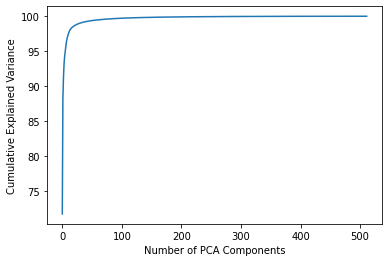

In [21]:
cum_component_variance = np.cumsum(pca_512.explained_variance_ratio_*100)
plt.plot(cum_component_variance)
plt.xlabel('Number of PCA Components')
plt.ylabel('Cumulative Explained Variance')

In [22]:
cum_component_variance[100]

99.7192775931904

In [23]:
pca_100 = PCA(n_components=100, random_state=4)
pca_100.fit(X)
X_pca = pca_100.transform(X)

In [24]:
clusters = [n for n in range(2,16)]
silhouette_coefficients = []

for cluster in clusters:
  kmeans = KMeans(n_clusters=cluster, random_state=420).fit(X_pca)
  labels = kmeans.labels_
  
  silhouette_avg = silhouette_score(X, labels)
  silhouette_coefficients.append(silhouette_avg)
  print("For n_clusters =",cluster, "The average silhouette_score is :",silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.5547956597082866
For n_clusters = 3 The average silhouette_score is : 0.47381100782295904
For n_clusters = 4 The average silhouette_score is : 0.4322246047230301
For n_clusters = 5 The average silhouette_score is : 0.3310143716704591
For n_clusters = 6 The average silhouette_score is : 0.3179455716225505
For n_clusters = 7 The average silhouette_score is : 0.2938474448390774
For n_clusters = 8 The average silhouette_score is : 0.288521999909058
For n_clusters = 9 The average silhouette_score is : 0.24957286051090244
For n_clusters = 10 The average silhouette_score is : 0.25818482939444437
For n_clusters = 11 The average silhouette_score is : 0.24073506144003978
For n_clusters = 12 The average silhouette_score is : 0.23240056815954993
For n_clusters = 13 The average silhouette_score is : 0.21867821721369557
For n_clusters = 14 The average silhouette_score is : 0.23875260210057295
For n_clusters = 15 The average silhouette_score is :

Text(0, 0.5, 'Silhouette Coefficients')

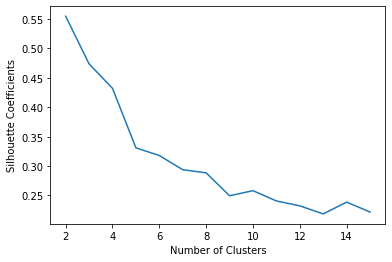

In [25]:
plt.plot(clusters, silhouette_coefficients)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Coefficients')

In [26]:
kmeans = KMeans(n_clusters=2, random_state=420).fit(X_pca)
cluster_labels = kmeans.labels_
print(f'There are {len(cluster_labels)} points, and {sum(cluster_labels)} points are in one cluster with {len(cluster_labels)-sum(cluster_labels)} in the other.')

There are 1488 points, and 947 points are in one cluster with 541 in the other.


In [70]:
X_embedded = TSNE(n_components=2, random_state=4).fit_transform(X)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


TypeError: ignored

In [28]:
# malignancy = list(map(lambda x:int(x), img_data[1]))
malignancy = list(map(lambda x:int(x), c.tolist()))

# malignancy = list(map(lambda x:int(x), shuffle_data[1][744:]))

In [30]:
lidc_TSNE = pd.DataFrame()
lidc_TSNE['nodule_id'] = lidc_cnnFeatures['nodule_id']#shuffle_id[744:]
lidc_TSNE['cluster_label'] = cluster_labels
lidc_TSNE['component_1'] = X_embedded[:,0]
lidc_TSNE['component_2'] = X_embedded[:,1]
lidc_TSNE['malignancy'] = malignancy

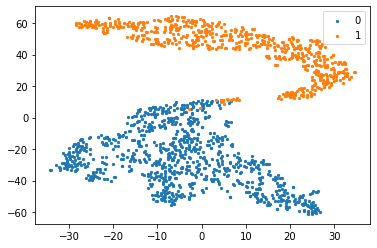

In [31]:
fig, ax = plt.subplots()
group = lidc_TSNE['malignancy']
component_1 = lidc_TSNE['component_1'].to_numpy()
component_2 = lidc_TSNE['component_2'].to_numpy()
# legend = {0:'red', 1:'blue'}

for g in np.unique(group):
    idx = np.where(group == g)
    ax.scatter(component_1[idx], component_2[idx],  label = g, s = 5) #c = legend[g],
ax.legend()
plt.show()

#Extract handcraft image features

In [256]:
from data_util import load_lidc, preprocess_data

In [257]:
df = preprocess_data(*load_lidc())

In [295]:
X = torch.tensor(df.drop(columns=['noduleID', 'malignancy', 'subgroup']).values).to(torch.float32)
y = torch.tensor(df['malignancy'].values).to(torch.long)
c= torch.tensor(df['noduleID'].values)

In [275]:
dataset = SubclassedNoduleDataset(X,y,c)
# loader = InfiniteDataLoader(dataset, batch_size=160)

In [276]:
len(dataset)

1417

In [286]:
tr, tst = torch.utils.data.random_split(dataset, [800,617])

In [287]:
loader, tst_loader = InfiniteDataLoader(tr, batch_size=160), InfiniteDataLoader(tst, batch_size=len(tst))

In [288]:
model = NeuralNetwork(64,36,36,2)
loss_fn = ERMLoss(model,torch.nn.CrossEntropyLoss(),{},subclassed=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.005)

In [90]:
# optimizer = torch.optim.Adam(model.parameters(), lr=0.000001, weight_decay=0.005)

In [289]:
epochs = 20
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    train(loader, model, loss_fn, optimizer, verbose=True)

Epoch 1/20
Average training loss: 0.6647556900978089
Epoch 2/20
Average training loss: 0.6133587718009949
Epoch 3/20
Average training loss: 0.5679227828979492
Epoch 4/20
Average training loss: 0.514391016960144
Epoch 5/20
Average training loss: 0.4578932702541351
Epoch 6/20
Average training loss: 0.41148294806480407
Epoch 7/20
Average training loss: 0.39248086214065553
Epoch 8/20
Average training loss: 0.3390419244766235
Epoch 9/20
Average training loss: 0.3493757426738739
Epoch 10/20
Average training loss: 0.38069928884506227
Epoch 11/20
Average training loss: 0.29849561452865603
Epoch 12/20
Average training loss: 0.3318291962146759
Epoch 13/20
Average training loss: 0.30766221284866335
Epoch 14/20
Average training loss: 0.292696139216423
Epoch 15/20
Average training loss: 0.2828132927417755
Epoch 16/20
Average training loss: 0.2912942945957184
Epoch 17/20
Average training loss: 0.321894234418869
Epoch 18/20
Average training loss: 0.3179780840873718
Epoch 19/20
Average training loss: 

In [290]:
weight = model.linear_relu_stack[0].weight.data
bias = model.linear_relu_stack[0].bias.data

weight1 = model.linear_relu_stack[2].weight.data
bias1 = model.linear_relu_stack[2].bias.data

In [291]:
# X,_,c = next(tst_loader)

In [296]:
X_trans = (weight @ X.t()).t() + bias
X_2 = torch.nn.functional.relu(X_trans)
X_final = (weight1@X_2.t()).t() + bias1
# X_final = model(X).data

In [297]:
cols = []
for idx,id in enumerate(c):#enumerate(shuffle_id[744:]):
  id = int(id)
  cols.append([id] + X_final[idx].cpu().numpy().tolist())
lidc_cnnFeatures = pd.DataFrame(cols).rename({0:'nodule_id'}, axis=1)
lidc_cnnFeatures.head()

,nodule_id,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
0,1,1.251320,0.089963,0.953432,-1.434130,3.029303,1.206498,2.058451,-1.620940,0.989212,...,1.808380,-0.486916,1.874573,0.274014,-0.933040,1.811895,2.095557,-0.668558,3.086583,1.408121
1,2,1.134337,0.093408,0.765104,-1.027439,2.702240,1.165762,1.795580,-1.152484,0.795335,...,1.604317,-0.407013,1.460032,0.141432,-0.613052,1.394647,1.814111,-0.652740,2.631060,1.307595
2,3,1.069349,0.026526,0.815630,-1.019015,2.646310,1.171535,1.870733,-1.408318,1.009166,...,1.585907,-0.415032,1.654244,0.178806,-0.927962,1.571154,1.934428,-0.463098,2.613842,1.269580
3,4,0.173887,-0.173805,0.019649,0.128700,0.365943,0.115916,0.240409,0.217695,0.144729,...,0.230537,0.184732,0.252948,0.076822,0.037769,0.089896,0.298016,0.380804,0.236251,0.179819
4,5,0.638468,0.136612,0.293359,-0.341745,1.564946,0.668135,0.773058,-0.320953,0.427528,...,0.811816,-0.034961,0.979301,-0.002034,-0.168476,0.552388,0.973380,-0.217124,1.403110,1.007064


In [298]:
lidc_cnnFeatures.to_csv('cnn_hc_8_features.csv')
